In [1]:
import os
import pandas as pd
import numpy as np
import json
import folium
from IPython.display import display, HTML
from ipywidgets import widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import branca.colormap as cm
from matplotlib import colors
import seaborn as sns
sns.set()

In [24]:
# Import the data of time series
df_refugee = pd.read_csv("time_series.csv",low_memory=False)
display(df_refugee.size)

# Change the values to numbers and set discard invalid
df_refugee['Value'] = pd.to_numeric(df_refugee['Value'], errors='coerce')
df_refugee= df_refugee[df_refugee['Value'] > 0]

#Only keep the entries that are in our temporal bounds
df_refugee = df_refugee[df_refugee['Year']>1984]
display(df_refugee.shape)

#Group every type of refugees
df_refugee = df_refugee.groupby(['Year','Country / territory of asylum/residence','Origin']).sum().reset_index()
df_refugee = df_refugee.rename(columns={"Year":"year","Value":"value"})
display(df_refugee.shape)

1492205

(161831, 5)

(111300, 4)

In [14]:
# Read the geo.csv file that will be used to map country to latitude and longitude
df_geo  = pd.read_csv("geo.csv",na_values ='NaN',keep_default_na =False)
display(df_geo.head())

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.93911,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [15]:
# Import the data of that is used to map the country code iso2 to iso3
df_isos = pd.read_csv("../docs/data/iso2_to_iso3.csv", sep=',')

# Import the data of population per year
df_pop = pd.read_csv("../docs/data/data_populations.csv")

# Merge the countries with the country codes iso3
df_pop = df_pop.merge(df_isos, left_on='Country Code', right_on='iso2')
df_pop = df_pop.drop(['Country Code', 'iso3'], 1)
df_pop = df_pop.rename(columns={'Value':'population', 'Year':'year'})
display(df_pop.head())

,year,population,iso2
0,1985,1391052.0,AE
1,1993,2207405.0,AE
2,1994,2328686.0,AE
3,1995,2448820.0,AE
4,1996,2571020.0,AE


In [16]:
# Merge the refugees country asylum with the latitude and the longitude
df_merge = df_refugee.merge(df_geo, left_on='Country / territory of asylum/residence', right_on='name', how='inner')
df_merge = df_merge[['year','value','Origin',"country"]]
df_merge = df_merge.rename(columns={"country" : "country_asylum"})

# Merge the refugees country origin with the latitude and the longitude
df_merge = df_merge.merge(df_geo, left_on='Origin', right_on='name', how='inner')
df_merge = df_merge[['year',"country","country_asylum",'value']]
df_merge = df_merge.rename(columns={"country":"country_origin"})

# Discard flows where the asylum is the same as the country of origin
df_merge = df_merge[df_merge['country_asylum']!=df_merge['country_origin']]

df_merge = df_merge.sort_values("year")

In [17]:
# Drop the asylum country to keep only the origin
df_immigration_exit = df_merge.drop("country_asylum",1)

# Group by year and country origin and sum
df_immigration_exit = df_immigration_exit.groupby(["year","country_origin"]).sum().reset_index()
df_immigration_exit= df_immigration_exit.sort_values(["country_origin","year"])
display(df_immigration_exit.head())

# Write the the country origin in the exit immigration
df_immigration_exit.to_csv("data_immigration_exit.csv", sep=',', encoding='utf-8',index = False)

,year,country_origin,value
893,1994,AD,2.0
1060,1995,AD,2.0
1232,1996,AD,3.0
1409,1997,AD,1.0
1588,1998,AD,2.0


In [18]:
# Drop the asylum country to keep only the origin
df_immigration_entry = df_merge.drop("country_origin",1)

# Group by year and country origin and sum
df_immigration_entry = df_immigration_entry.groupby(["year","country_asylum"]).sum().reset_index()
df_immigration_entry= df_immigration_entry.sort_values(["country_asylum","year"])
df_immigration_entry = df_immigration_entry[["country_asylum","year","value"]]
display(df_immigration_entry.head())

# Write the the country asylum in the entry immigration
df_immigration_entry.to_csv("data_immigration_entry.csv", sep=',', encoding='utf-8',index = False)

,country_asylum,year,value
0,AE,1985,6350.0
619,AE,1993,427.0
751,AE,1994,474.0
882,AE,1995,404.0
1016,AE,1996,450.0


In [19]:
import math
def keepNonNan(country_origin,country_asylum):
    """
    If the country origin is equal to 0, return country asylum, on the other case return the country asylum
    """
    if (country_origin == 0):
        return country_asylum
    if (country_asylum == 0):
        return country_origin 
    return country_origin

In [20]:
# Merge the entries and the exits on year and country origin/asylum
df_immigration_delta = df_immigration_entry.merge(df_immigration_exit,right_on=['year','country_origin'], left_on=['year','country_asylum'], how='outer')
df_immigration_delta = df_immigration_delta.fillna(0)
df_immigration_delta['country'] = df_immigration_delta.apply(lambda x:keepNonNan(x['country_origin'],x['country_asylum']),axis = 1)

# Caltulate deltas
df_immigration_delta = df_immigration_delta[df_immigration_delta.country != 0]
df_immigration_delta['value'] = df_immigration_delta.value_x - df_immigration_delta.value_y

# Only keep year, country and deltas
df_immigration_delta = df_immigration_delta[["year","country","value"]]
df_immigration_delta = df_immigration_delta.sort_values(["year","country"])
display(df_immigration_delta.head())

,year,country,value
0,1985,AE,6350.0
4328,1985,AF,-4654343.0
4353,1985,AL,-3067.0
4360,1985,AM,-333.0
104,1985,AO,-226502.0


In [21]:
# Merge on the year and the country code iso2 from the delta data and the population data
df_immigration_props = df_immigration_delta.merge(
    df_pop,
left_on=['year', 'country'],
right_on=['year', 'iso2'],
how='left')

# Calculate fraction of the delta over the population
df_immigration_props['per_million'] = 1e6 * df_immigration_props['value'] / df_immigration_props['population']
df_immigration_props['per_million'] = df_immigration_props['per_million'].fillna(0)
df_immigration_props = df_immigration_props.drop(['value', 'iso2', 'population'], axis=1)

# Display ratios in Syria
display(df_immigration_props[df_immigration_props.country=='SY'])

# Write the fraction data in data_population_fraction.csv
df_immigration_props.to_csv("data_population_fraction.csv", sep=',', encoding='utf-8',index = False)

,year,country,per_million
87,1985,SY,3449.363261
188,1986,SY,8.723885
289,1987,SY,0.000000
399,1988,SY,-57.257098
517,1989,SY,0.000000
642,1990,SY,158.844033
778,1991,SY,86.849862
921,1992,SY,131.340626
1078,1993,SY,2439.220927
1245,1994,SY,2363.133766


In [22]:
print(np.linspace(0.09,1,10, endpoint=False))

[ 0.09   0.181  0.272  0.363  0.454  0.545  0.636  0.727  0.818  0.909]


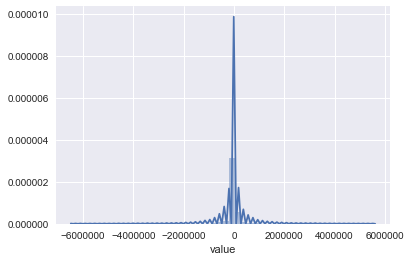

array([-5821.26402522,  -549.06799585,   -17.24285539,     0.        ,
           0.        ,    13.83158458,   181.64910404,   976.89699822,
        3215.67208069,  9600.52889319])

In [23]:
sns.distplot(df_immigration_delta.value)
plt.show()
np.set_printoptions(suppress=True)

# Calculate the quantiles of the fractions
df_immigration_props.per_million.quantile(np.linspace(0.09,1,10, endpoint=False), interpolation='nearest').values